I have adapted this notebook from an assignment I submitted for a Data Analytics module for my PGDip. It's my first Kaggle notebook. I will most likely add more to it - like how to interpret the resulting MLR equation and add some residual plots. If you have any tips or suggestions, please let me know.

# 1. Introduction

**Health Insurance in the US**

Health insurance is a means for financing a person’s or persons' health care expenses. In the US the majority of people have private health insurance, usually obtained through a current employer, and the minority are covered through government sponsored programmes [(1)](#References).

The insurer calculates premiums for their insurance policies relying on two primary factors - the cost the insurer predicts to pay under their policies, and the cost of operating particular policies or plans. The cost of medical expenses are calculated in many ways - the policyholder's health status, region of residence, employment status, and wages can all be included in the estimate [(2)](#References).


**Regression analysis**

In terms of statistical methods, regression analysis is often used to estimate healthcare costs and calculate insurance premiums. A policyholder's medical expenses can be influenced by a myriad of factors, such as their habits, chronic illnesses, age, economic factors, occupational hazards, place of residence, and so on. Regression analysis can be used to identify the factors that are significant in their influence on medical costs. Regression analysis can also be used to predict the true cost of an insurance policy, allowing for insurance companies to set competitive prices. Setting the same price for all policyholders is not a competitive strategy as those with low expenses would overpay and possibly leave the service, and those with high expenses would remain using the service and make a loss of the insurance company. Regression models are tools that can be used to establish proper classification systems that offer a fair price to customers and maximise the company's profits [(3)](#References).

## 1.1 Dataset

The [dataset] for this report comes from the book Machine Learning with R by Brett Lantz and is in the public domain. The dataset includes information about the insurance policy holder, their dependents, and their medical expenses throughout a year.

[dataset]: https://www.kaggle.com/mirichoi0218/insurance

* **Age**: Age of primary policyholder.
* **Sex**: Sex of the policy policyholder.
* **BMI**: Body Mass Index of policyholder, defined as the body mass divided by the square of the body height (kg/m2).
* **Smoker status**: Whether the policyholder is a smoker or a non-smoker.
* **Children**: Number of children/dependents covered in the policy.
* **Region of residence**: Residential areas of the policy holder (in the US) - North East, South East, South West, North West.
* **Charges**: Yearly medical expenses billed by the medical insurance provider ($).

## 1.2 Aims

* To determine if there is a relationship between attributes and medical costs.
* To determine if there a significant difference in medical costs between different groups.
* To fit a multiple linear regression to predict costs.

# 2. Import and pre-processing

In [ ]:
suppressMessages(library(tidyverse))        # data manipulation and plots
suppressMessages(library(funModeling))      # overview stats

library(magrittr)               # to use pipes
library(skimr)                  # to get a quick summary table
library(caret)                  # to create the partition for training/test datasets

options(scipen = 999)                              # turn off scientific notation for numbers
options(repr.plot.width=12, repr.plot.height=8)    # set universal plot size

In [ ]:
# read the file in
df <- read.csv('insurance.csv')

# denote factor variables
df$sex <- factor(df$sex)
df$smoker <- factor(df$smoker)
df$region <- factor(df$region)
df$children <- factor(df$children)

In [ ]:
# check for missing values
df %>%
    is.na() %>%
    sum()

In [4]:
# check data types
df %>%
    str()

spec_tbl_df [1,338 × 7] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ age     : num [1:1338] 19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : Factor w/ 2 levels "female","male": 1 2 2 2 2 1 1 1 2 1 ...
 $ bmi     : num [1:1338] 27.9 33.8 33 22.7 28.9 ...
 $ children: Factor w/ 6 levels "0","1","2","3",..: 1 2 4 1 1 1 2 4 3 1 ...
 $ smoker  : Factor w/ 2 levels "no","yes": 2 1 1 1 1 1 1 1 1 1 ...
 $ region  : Factor w/ 4 levels "northeast","northwest",..: 4 3 3 2 2 3 3 2 1 2 ...
 $ charges : num [1:1338] 16885 1726 4449 21984 3867 ...
 - attr(*, "spec")=
  .. cols(
  ..   age = col_double(),
  ..   sex = col_character(),
  ..   bmi = col_double(),
  ..   children = col_double(),
  ..   smoker = col_character(),
  ..   region = col_character(),
  ..   charges = col_double()
  .. )


**Summary**

* There are no missing values.
* All columns are assigned correct data types.

# 3. Exploratory data analysis

## 3.1 Overview

In [5]:
skim(df)

── Data Summary ────────────────────────
                           Values
Name                       df    
Number of rows             1338  
Number of columns          7     
_______________________          
Column type frequency:           
  factor                   4     
  numeric                  3     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 sex                   0             1 FALSE          2
2 children              0             1 FALSE          6
3 smoker                0             1 FALSE          2
4 region                0             1 FALSE          4
  top_counts                            
1 mal: 676, fem: 662                    
2 0: 574, 1: 324, 2: 240, 3: 157        
3 no: 1064, yes: 274                    
4 sou: 364, nor: 325, sou: 325, nor: 324

── Variable type: numeric ────────────────────

**Findings:**
* There are four numerical variables:
    * Continuous:
        * Age
        * BMI
        * Charges
    * Discrete:
        * Dependents
* There are three categorical variables:
    * Sex
    * Smoker
    * Region
* No missing values

## 3.2 Distributions of variables

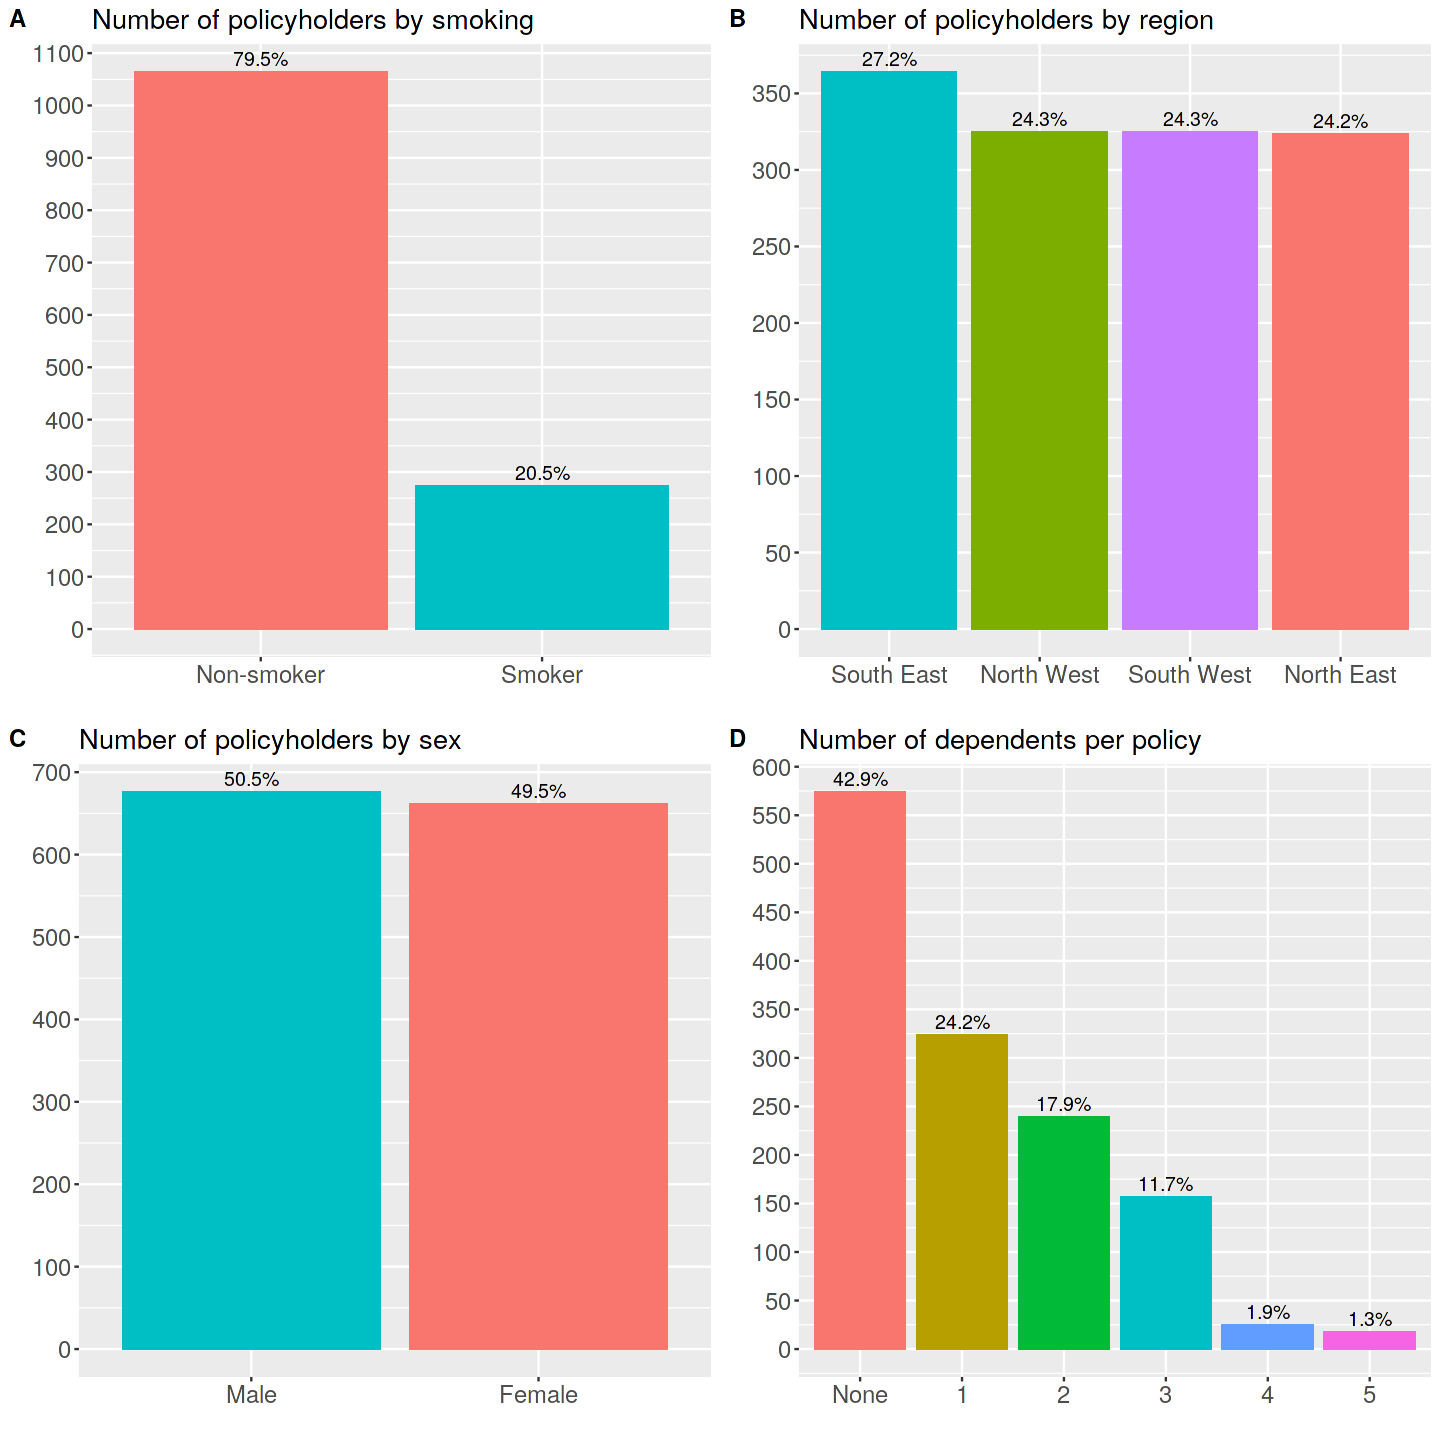

In [6]:
figsize <- options(repr.plot.width=12, repr.plot.height=12) # set plot size for this plot 

# Smoker count plot
smoker <- df %>%
    ggplot(aes(x=smoker, fill=smoker)) +
    geom_bar(show.legend = FALSE) +
    # add percentages on top of bars
    geom_text(
        stat='count',
        aes(label=paste0(round(after_stat(prop*100), digits=1), "%"),group=1),
        vjust=-0.4,
        size=4
    ) +
    # add labels
    labs(
        x = "",
        y = "",
        title = "Number of policyholders by smoking"
    ) +
    # rename x-ticks
    scale_x_discrete(
        labels = c("no" = "Non-smoker", "yes" = "Smoker")
    ) +
    # adjust y-ticks
    scale_y_continuous(
        breaks=seq(0,2000,100)
    ) +
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14)
    )

# Region count plot
region <- df %>%
    ggplot(aes(x=forcats::fct_infreq(region), fill=region)) +
    geom_bar(show.legend = FALSE) +
    # add percentages on top of bars
    geom_text(
        stat='count',
        aes(label = paste0(round(after_stat(prop*100), digits=1), "%"), group=1),
        vjust=-0.4,
        size=4
    ) +
    # add labels
    labs(
        x = "",
        y = "",
        title = "Number of policyholders by region"
    ) +
    # rename x-ticks
    scale_x_discrete(
        labels = c("northeast" = "North East", "northwest" = "North West",
                   "southeast" = "South East", "southwest" = "South West")
    ) +
    # adjust ticks
    scale_y_continuous(
        breaks=seq(0,350,50)
    ) +
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14)
    )

# Sex count plot
sex <- df %>%
    ggplot(aes(x=forcats::fct_infreq(sex), fill=sex)) +
    geom_bar(show.legend = FALSE) +
    # add percentages on top of bars
    geom_text(
        stat='count',
        aes(
            label=paste0(round(after_stat(prop*100), digits=1), "%"), group=1),
        vjust=-0.4,
        size=4
    ) +
    # add labels
    labs(
        x = "",
        y = "",
        title = "Number of policyholders by sex",
        fill = "Sex"
    ) +
    # rename x-ticks
    scale_x_discrete(
        labels = c("male" = "Male", "female" = "Female")
    ) +
    # adjust y-ticks
    scale_y_continuous(
        breaks=seq(0,700,100)
    ) +
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14)
    )

# Children count plot
children <- df %>%
    ggplot(aes(x=forcats::fct_infreq(children), fill=children)) +
    geom_bar(show.legend = FALSE) +
    # add percentages
    geom_text(
        stat='count',
        aes(label=paste0(round(after_stat(prop*100), digits=1), "%"), group=1),
        vjust=-0.4,
        size=4
    ) +
    # add labels
    labs(
        x = "",
        y = "",
        title = "Number of dependents per policy"
    ) +
    # rename x-ticks
    scale_x_discrete(
        labels = c("0" = "None")
    ) +
    # adjust y-ticks
    scale_y_continuous(
        breaks=seq(0,600,50)
    ) +
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text.x = element_text(size=14),
        axis.text.y = element_text(size=14)
    )

# Plot grid
cowplot::plot_grid(
  smoker, region, sex, children,
  labels="AUTO",
  ncol = 2,
  nrow = 2
    )

options(figsize)

**Summary**

* **Smoking status**: There are many more non-smokers (80%) than smokers (20%).
* **Region of residence**: Policyholders are evenly distributed across regions with South East being the most populous one (27%) with the rest of regions containing around 24% of policyholders each.
* **Sex**: There are slightly more men (51%) than there are women (49%) in the sample.
* **Dependents**: Most policyholders (43%) do not have dependents covered in their policy. For those who do have dependents covered in their policy, most have one dependent (24%). Maximum number of dependents covered is five (1%).

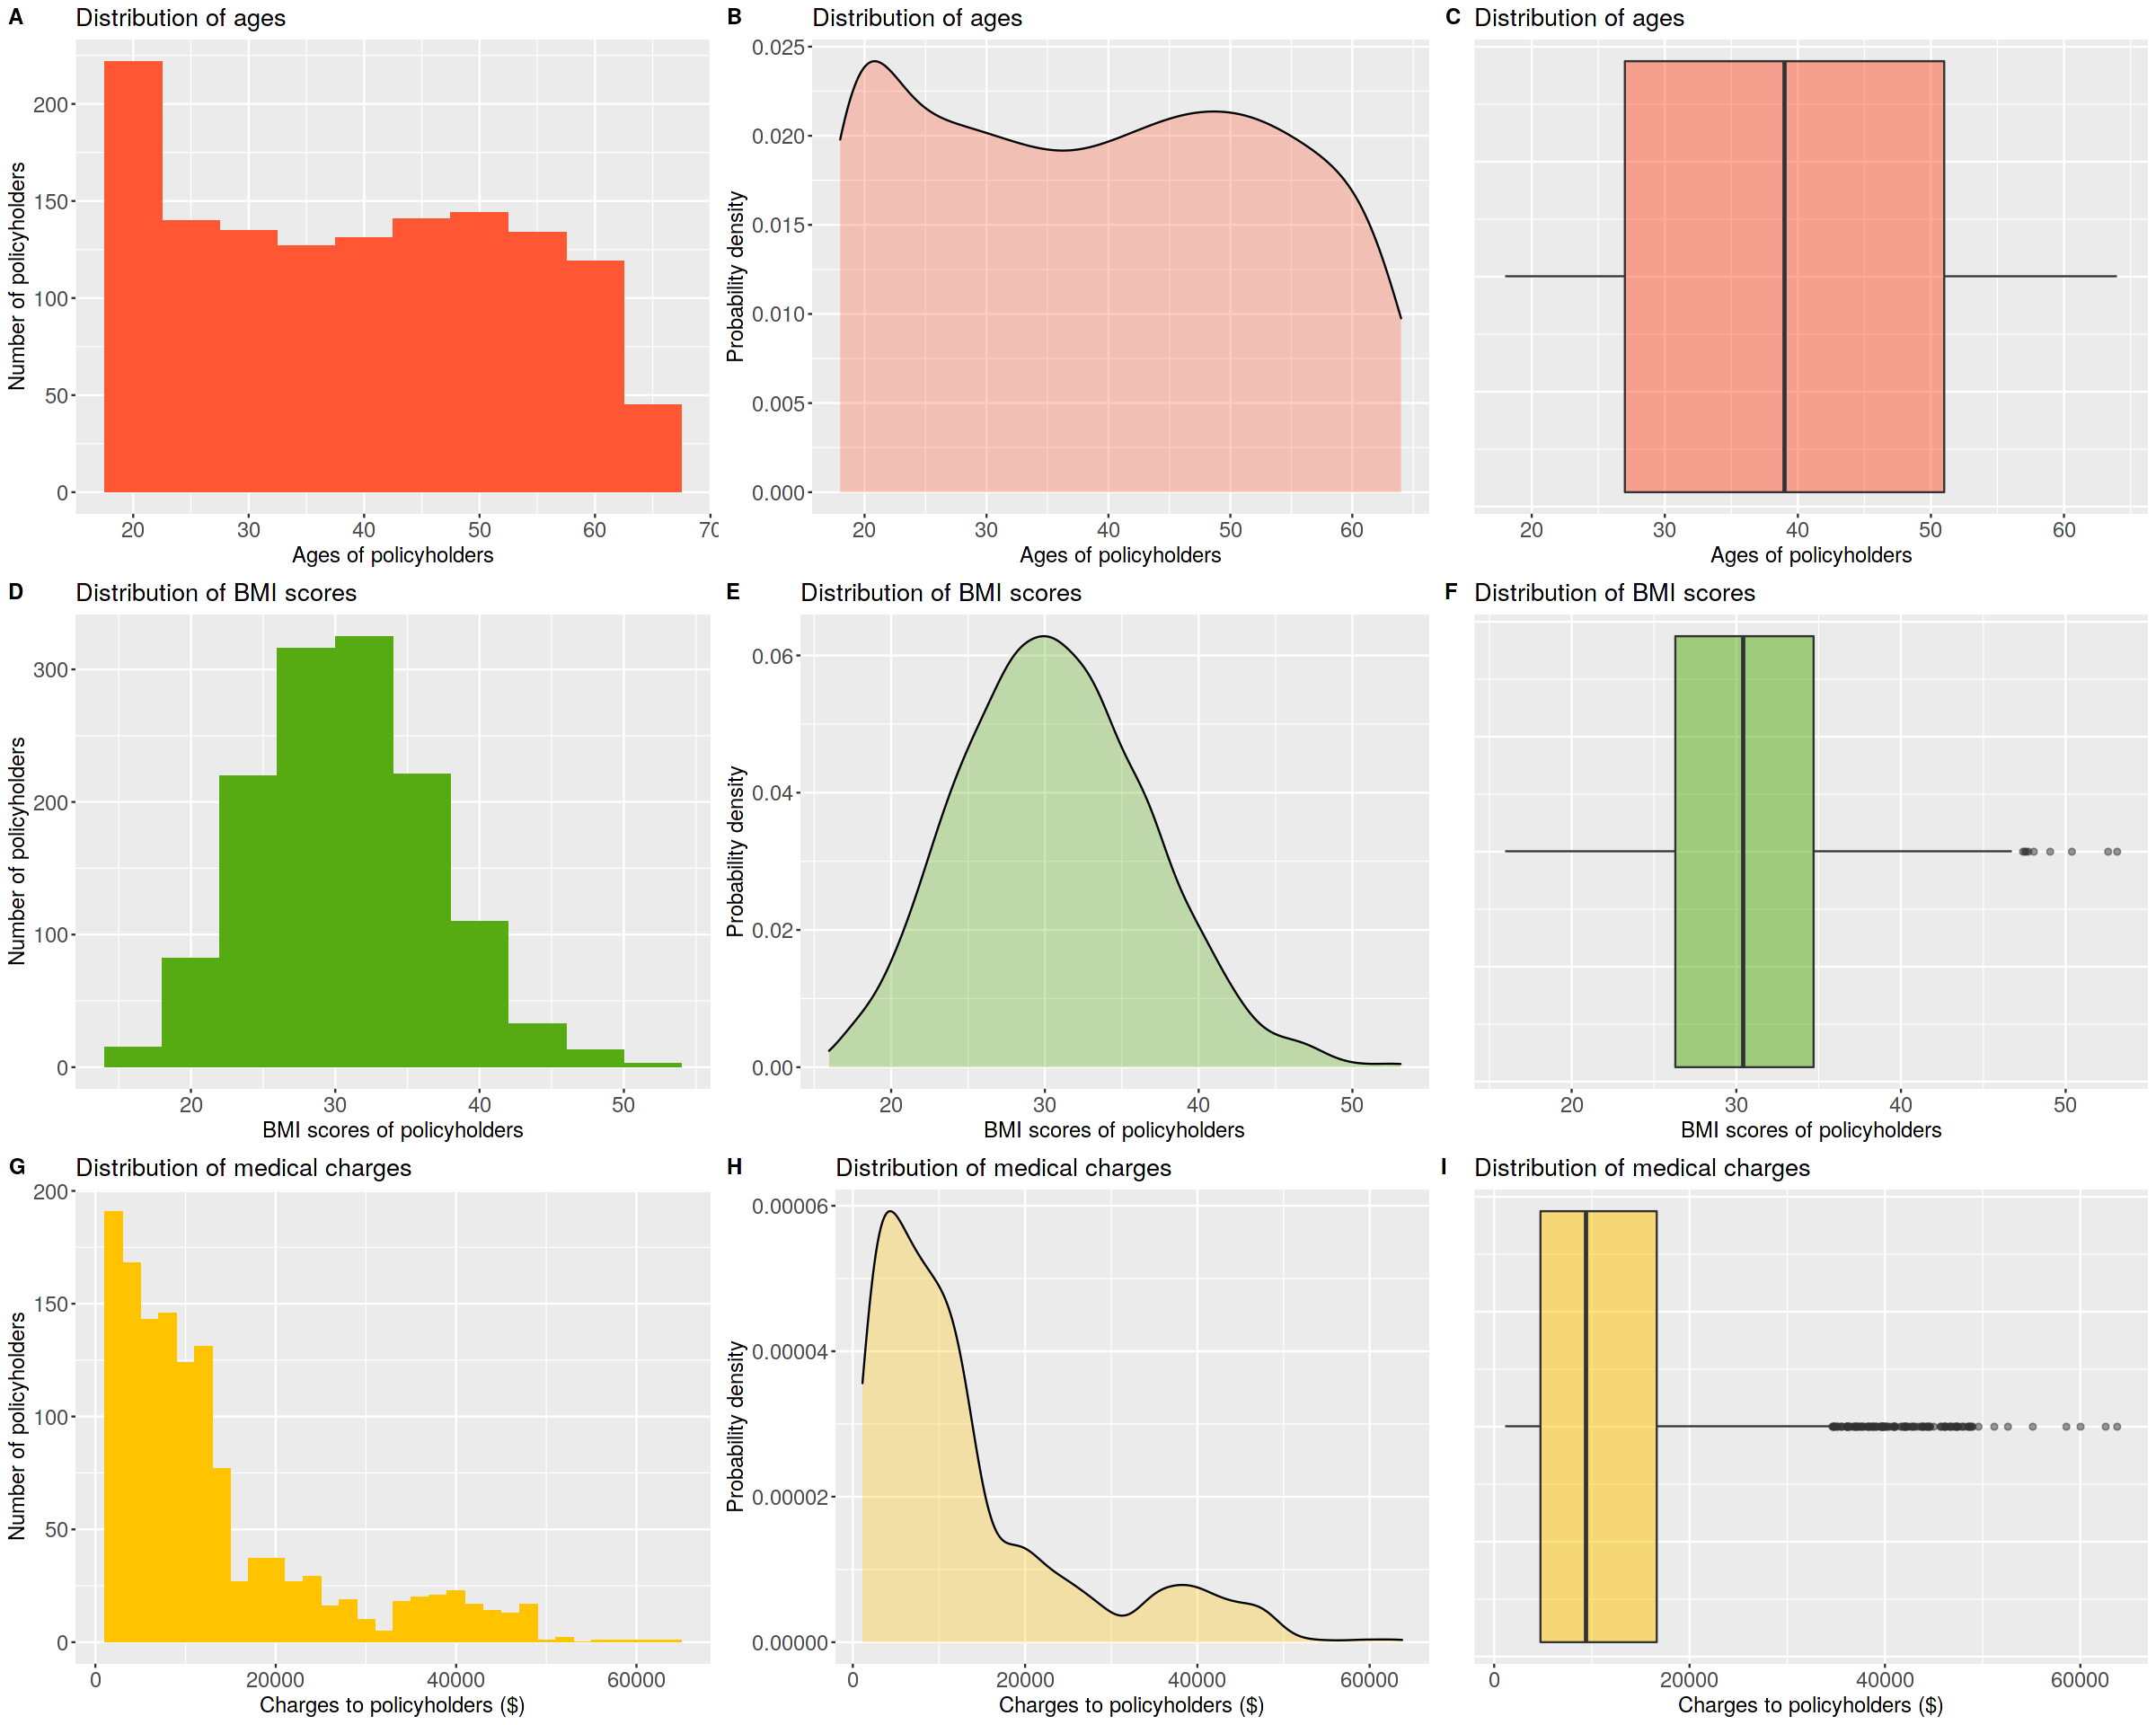

In [7]:
figsize <- options(repr.plot.width=20, repr.plot.height=16)

# Age distribution
age_hist <- df %>%
    ggplot(aes(x=age))+
    geom_histogram(
        binwidth = 5,
        show.legend = FALSE,
        fill="#ff5733"
    )+
    labs(
        x = "Ages of policyholders",
        y = "Number of policyholders",
        title = "Distribution of ages"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

age_dens <- df %>%
    ggplot(aes(x=age)) +
     geom_density(
        alpha=.3,
        fill="#ff5733"
    )+
    labs(
        x = "Ages of policyholders",
        y = "Probability density",
        title = "Distribution of ages"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

age_box <- df %>%
    ggplot(aes(y=age)) +
    geom_boxplot(
        alpha=.5,
        fill="#ff5733"
    )+
    coord_flip() +
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )+
    labs(
        y = "Ages of policyholders",
        x = "",
        title = "Distribution of ages"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

# BMI distribution
bmi_hist <- df %>%
    ggplot(aes(x=bmi))+
    geom_histogram(
        binwidth = 4,
        show.legend = FALSE,
        fill = "#55ab11"
    )+
    labs(
        x = "BMI scores of policyholders",
        y = "Number of policyholders",
        title = "Distribution of BMI scores"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_dens <- df %>%
    ggplot(aes(x=bmi)) +
     geom_density(
        alpha=.3,
        fill="#55ab11"
    )+
    labs(
        x = "BMI scores of policyholders",
        y = "Probability density",
        title = "Distribution of BMI scores"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_box <- df %>%
    ggplot(aes(y=bmi)) +
    geom_boxplot(
        alpha=.5,
        fill="#55ab11"
    )+
    coord_flip() +
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )+
    labs(
        y = "BMI scores of policyholders",
        x = "",
        title = "Distribution of BMI scores"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

# Charges distribution
charges_hist <- df %>%
    ggplot(aes(x=charges)) +
    geom_histogram(
        binwidth = 2000,
        show.legend = FALSE,
        fill = "#FFC300"
    )+
    labs(
        x = "Charges to policyholders ($)",
        y = "Number of policyholders",
        title = "Distribution of medical charges"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

charges_dens <- df %>%
    ggplot(
        aes(x=charges)
    ) +
     geom_density(
        alpha=.3,
        fill="#FFC300"
    ) +
    labs(
        x = "Charges to policyholders ($)",
        y = "Probability density",
        title = "Distribution of medical charges"
    ) +
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

charges_box <- df %>%
    ggplot(aes(y=charges))+
    geom_boxplot(
        alpha=.5,
        fill="#FFC300"
    )+
    coord_flip()+
    # remove ticks from y-axis
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )+
    labs(
        y = "Charges to policyholders ($)",
        x = "",
        title = "Distribution of medical charges"
    )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

cowplot::plot_grid(
    age_hist, age_dens, age_box,
    bmi_hist, bmi_dens, bmi_box,
    charges_hist, charges_dens, charges_box,
    labels="AUTO",
    ncol = 3,
    nrow = 3
    )

options(figsize)

**Summary**

* **Age**: Youngest policyholder is 18 and the eldest is 64. All ages in the range are represented fairly equally apart from the youngest and eldest policyholders. 18-23-year-olds are the most populous group (among all 5-year segments) and 60-64-year-olds are the least represented 5-year age group. There are no outliers.
* **BMI**: BMI is normally distributed with the smallest and the largest values being the least common and median and mean being almost identical. There are a few outliers on the larger side. Minimum recorded BMI score is 16 and maximum is 53.1.
* **Charges**: Charges are heavily right-skewed with many outliers on the larger side. This means most charges are fairly low with a few particularly high charges. Smallest charge is \\$1,122 and largest charge is $63,770.

## 3.3. Charges vs all other factors

Since the expenses are not normally distributed, it is not helpful to compare the means. Medians are compared below in box plot (A-D) and violin plot graphs (E-H).

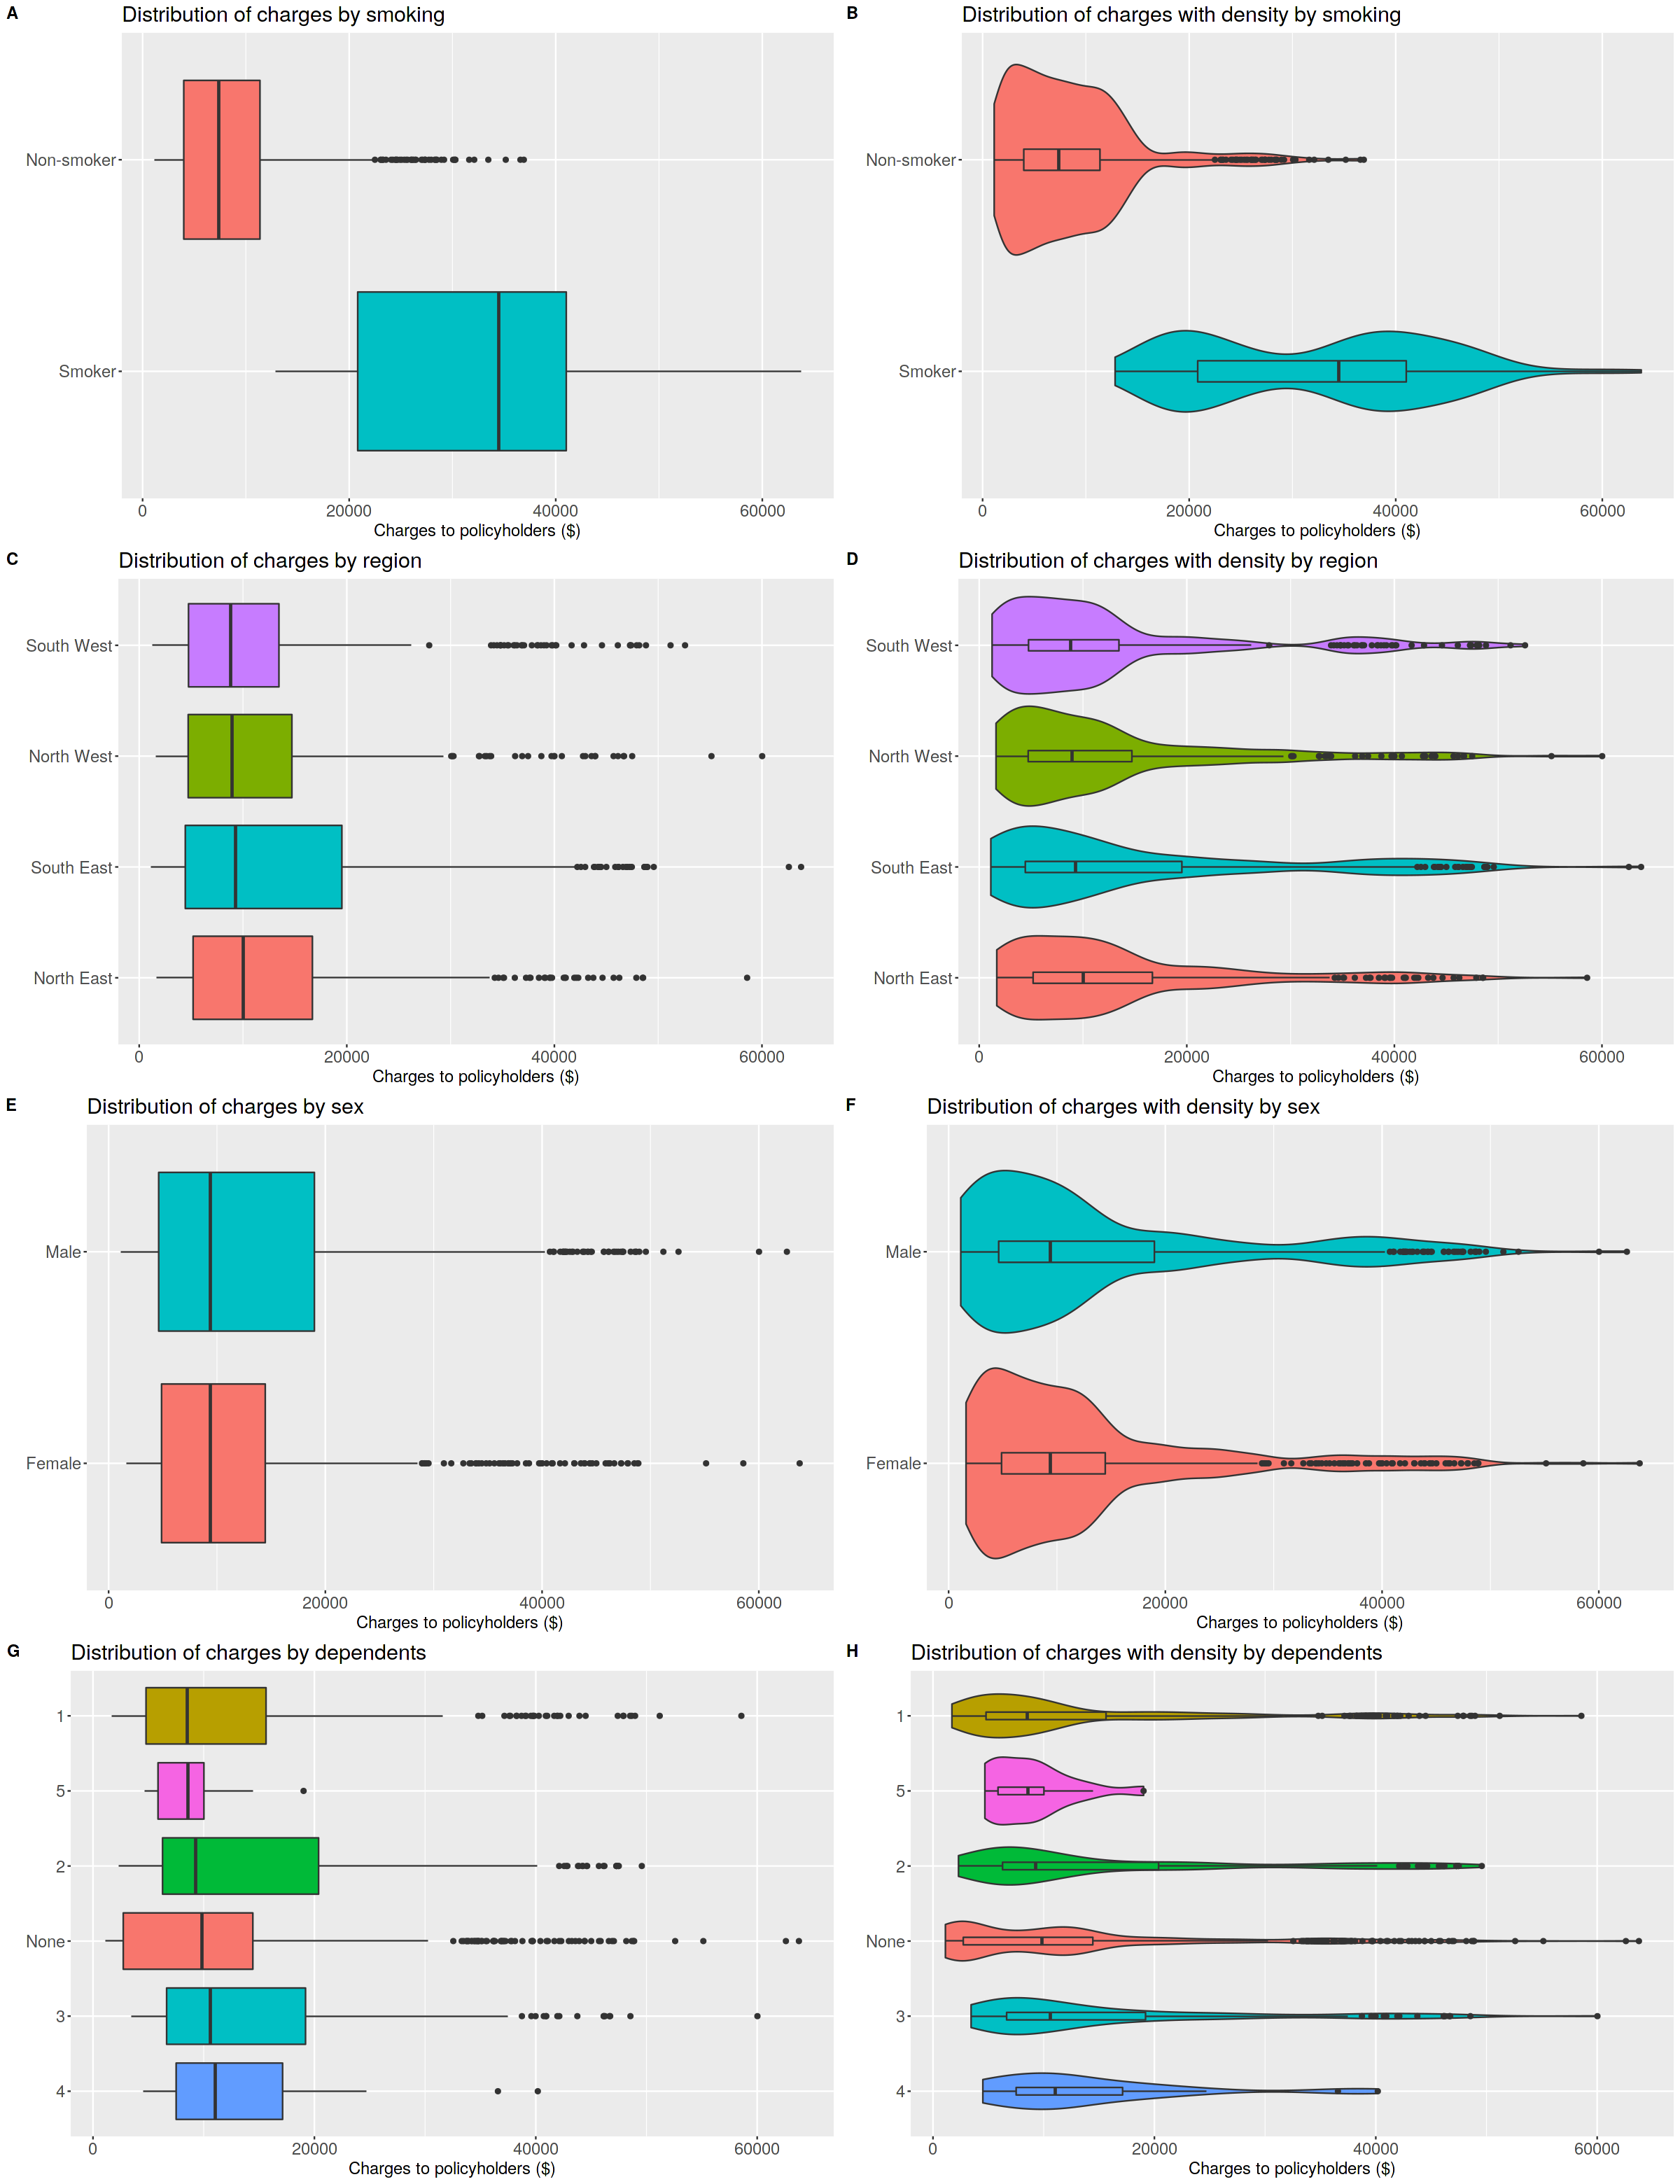

In [8]:
figsize <- options(repr.plot.width=20, repr.plot.height=26)

# Boxplots
chargesBysmoker <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(smoker, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=smoker
            )
        ) +
    geom_boxplot(show.legend = FALSE) +
    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges by smoking"
    )+
    scale_x_discrete(
        labels = c("no" = "Non-smoker", "yes" = "Smoker")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )
    
chargesByregion <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(region, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=region
            )
        ) +
    geom_boxplot(show.legend = FALSE) +
    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges by region"
    )+
    scale_x_discrete(
        labels = c("northeast" = "North East", "northwest" = "North West",
                    "southeast" = "South East", "southwest" = "South West")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

chargesBychildren <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(children, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=children
            )
        ) +
    geom_boxplot(show.legend = FALSE) +
    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges by dependents"
    )+
    scale_x_discrete(
        labels = c("0" = "None")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

chargesBysex <- df %>%
    ggplot(
    aes(
        x=forcats::fct_reorder(sex, charges, .fun=median, .desc=TRUE),
        y=charges,
        fill=sex
        )
    ) +
    geom_boxplot(show.legend = FALSE) +
    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges by sex"
    )+
    scale_x_discrete(
        labels = c("male" = "Male", "female" = "Female")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

# Density plots with medians
densityBySmoker <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(smoker, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=smoker
            )
        ) +
    geom_violin(show.legend = FALSE) +
    geom_boxplot(
        width=0.1,
        show.legend = FALSE
    )+
    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges with density by smoking"
    )+
    scale_x_discrete(
        labels = c("no" = "Non-smoker", "yes" = "Smoker")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

densityByRegion <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(region, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=region
            )
        ) +
    geom_violin(show.legend = FALSE) +
    geom_boxplot(
        width=0.1,
        show.legend = FALSE
    )+    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges with density by region"
    )+
    scale_x_discrete(labels = c("northeast" = "North East", "northwest" = "North West",
                                "southeast" = "South East", "southwest" = "South West")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

densityBySex <- df %>%
    ggplot(
    aes(
        x=forcats::fct_reorder(sex, charges, .fun=median, .desc=TRUE),
        y=charges,
        fill=sex
        )
    ) +
    geom_violin(show.legend = FALSE) +
    geom_boxplot(
        width=0.1,
        show.legend = FALSE
    )+    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges with density by sex"
    )+
    scale_x_discrete(
        labels = c("male" = "Male", "female" = "Female")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

densityByChildren <- df %>%
    ggplot(
        aes(
            x=forcats::fct_reorder(children, charges, .fun=median, .desc=TRUE),
            y=charges,
            fill=children
            )
        ) +
    geom_violin(show.legend = FALSE) +
    geom_boxplot(
        width=0.1,
        show.legend = FALSE
    )+    coord_flip() +
    labs(
        x = "",
        y = "Charges to policyholders ($)",
        title = "Distribution of charges with density by dependents"
    )+
    scale_x_discrete(
        labels = c("0" = "None")
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

# Plot grid of all plots
cowplot::plot_grid(
    chargesBysmoker, densityBySmoker,
    chargesByregion, densityByRegion,
    chargesBysex, densityBySex,
    chargesBychildren, densityByChildren,
    labels="AUTO",
    ncol = 2,
    nrow = 4
)

options(figsize)

**Summary**

* **Smoking**: There is a big difference in medians between smokers (\\$34,456) and non-smokers (\\$7,345). Non-smokers show many outliers on the larger side, while the vast majority of charges are on the smaller side. Smokers show bimodal distribution and no outliers.
    * Larger charges for smokers are to be expected as smoking is a known serious health risk.
* **Region of residence**: There are slight differences in medians between all groups. All groups have outliers. The spread of values is fairly similar for all groups apart from South East which has a larger interquartile range (IQR).
* **Sex**: Males have a marginally larger median (\\$9,413) than females (\\$9,370), a difference of just $43. Both groups show outliers on the larger side. The spread of values is fairly similar.
* **Dependents**: There are some differences in medians between the groups, but they are not drastic.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



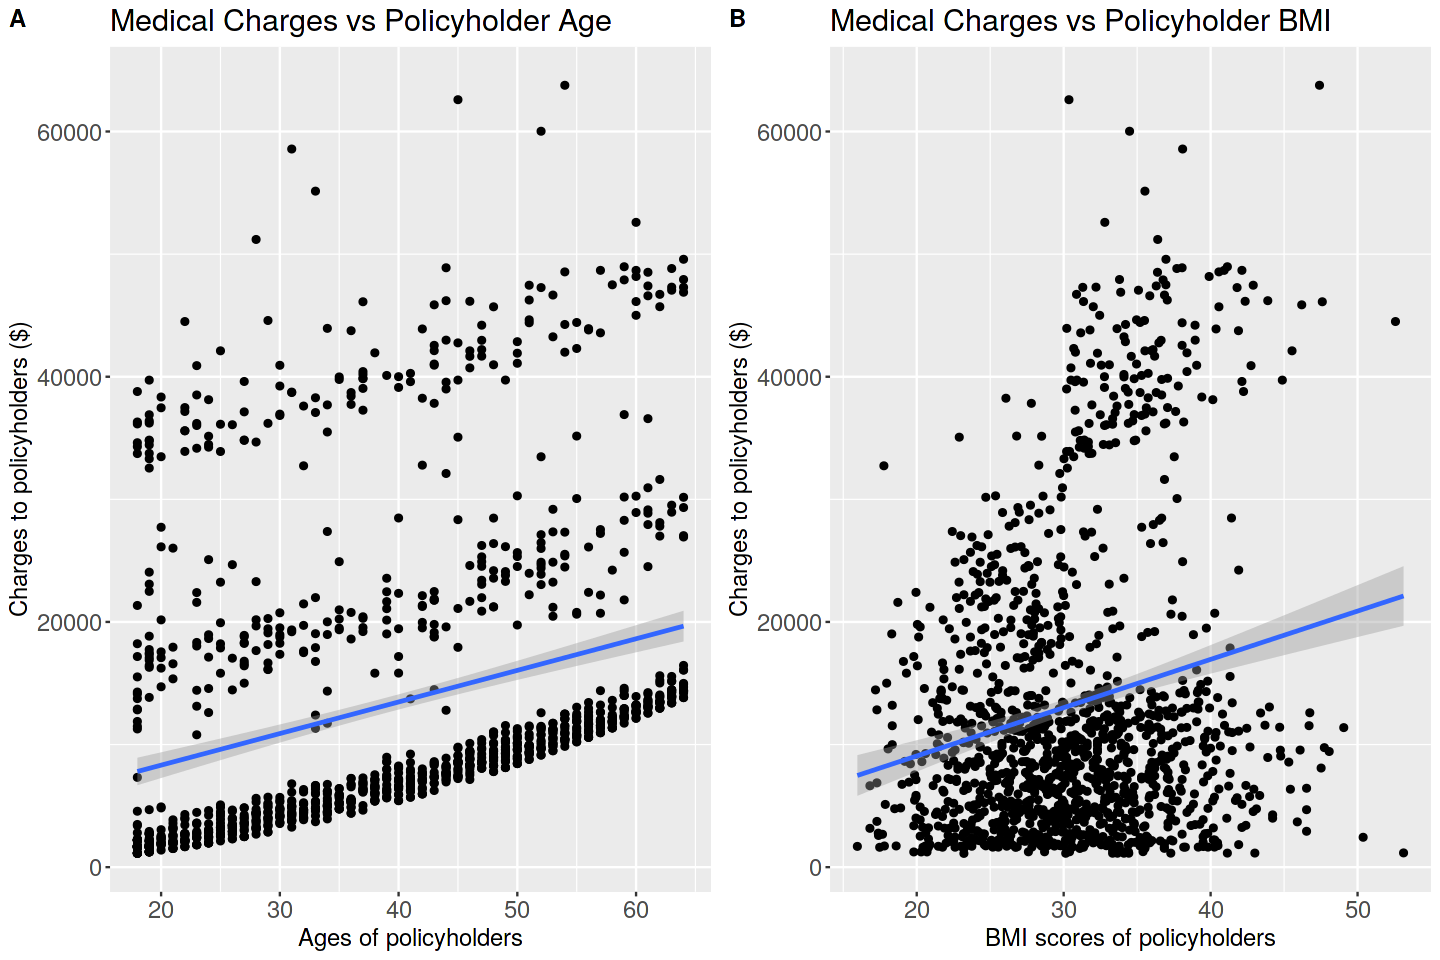

In [9]:
figsize <- options(repr.plot.width=12, repr.plot.height=8)

age_scatter <- df %>%
    ggplot(aes(x=age, y=charges)) +
    geom_point()+
    # add a linear regression line
    geom_smooth(method='lm')+
    labs(
        x = "Ages of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder Age"
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_scatter <- df %>%
    ggplot(aes(x=bmi, y=charges)) +
    geom_point()+
    # add a linear regression line
    geom_smooth(method='lm')+
    labs(
        x = "BMI scores of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder BMI"
    )+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

cowplot::plot_grid(
  age_scatter, bmi_scatter,
  labels="AUTO",
  ncol = 2,
  nrow = 1
    )

options(figsize)

**Summary**

* **Medical Charges vs Policyholder Age**: There are interesting patterns here, showing three groups. The lower band shows a very strong relationship between medical charges and age, with two other bands showing a less strong relationship. The general trend is a positive correlation, meaning as age increases, so do medical expenses.
* **Medical charges vs Policyholder BMI**: There is a positive relationship between BMI and medical expenses, meaning people with higher BMI scores have higher medical bills. The relationship is not, however, very strong. There are possibly two groups to the scatter plot, judging by the spread of points above and below the regression line.

Next, these scatter plots are grouped by categorical variables in the dataset.

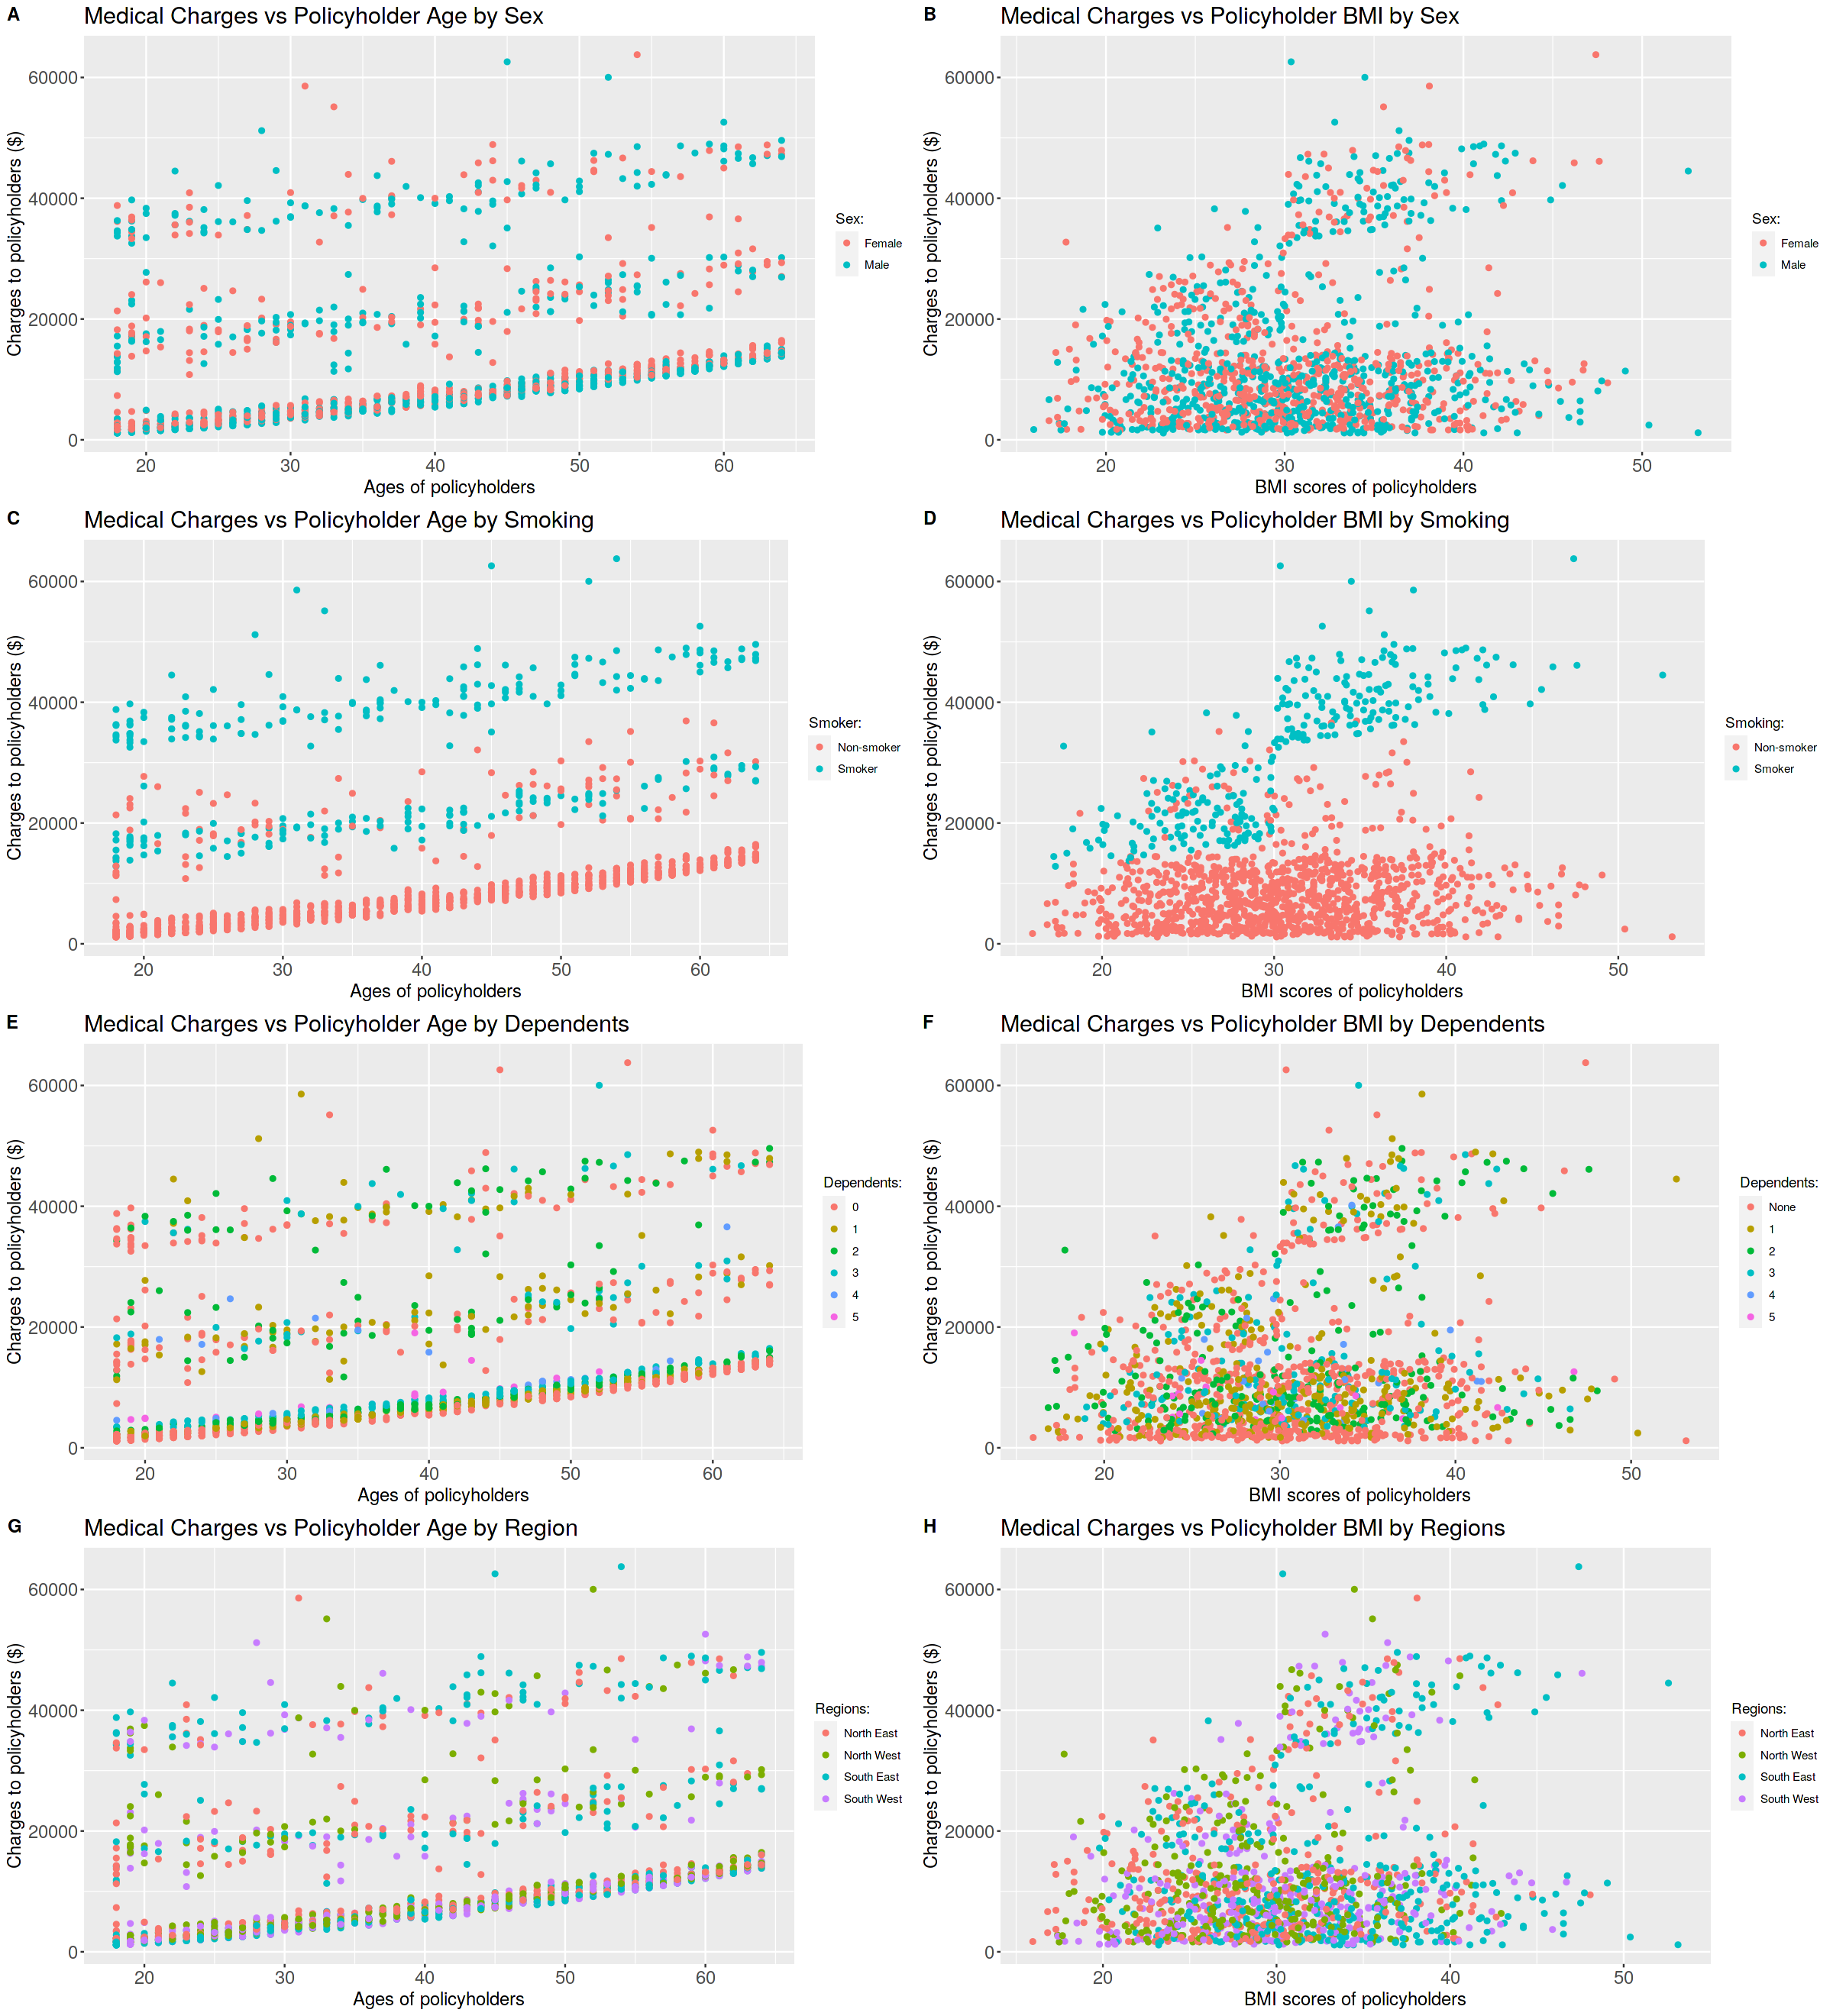

In [10]:
figsize <- options(repr.plot.width=20, repr.plot.height=22)

# by sex
age_scatter_sex <- df %>%
    ggplot(aes(x=age, y=charges, color=sex)) +
    geom_point()+
    labs(
        x = "Ages of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder Age by Sex",
        color = "Sex:"
    )+
    scale_color_hue(labels = c("male" = "Male", "female" = "Female"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_scatter_sex <- df %>%
    ggplot(aes(x=bmi, y=charges, color=sex)) +
    geom_point()+
    labs(
        x = "BMI scores of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder BMI by Sex",
        color = "Sex:"
    )+
    scale_color_hue(labels = c("male" = "Male", "female" = "Female"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

#by smoker
age_scatter_smoker <- df %>%
    ggplot(aes(x=age, y=charges, color=smoker)) +
    geom_point()+
    labs(
        x = "Ages of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder Age by Smoking",
        color = "Smoker:"
    )+
    scale_color_hue(labels = c("no" = "Non-smoker", "yes" = "Smoker"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_scatter_smoker <- df %>%
    ggplot(aes(x=bmi, y=charges, color=smoker)) +
    geom_point()+
    labs(
        x = "BMI scores of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder BMI by Smoking",
        color = "Smoking:"
    )+
    scale_color_hue(labels = c("no" = "Non-smoker", "yes" = "Smoker"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

#by children
age_scatter_kids <- df %>%
    ggplot(aes(x=age, y=charges, color=children)) +
    geom_point()+
    labs(
        x = "Ages of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder Age by Dependents",
        color = "Dependents:"
    )+
    scale_color_hue(labels = c("no" = "Non-smoker", "yes" = "Smoker"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_scatter_kids <- df %>%
    ggplot(aes(x=bmi, y=charges, color=children)) +
    geom_point()+
    labs(
        x = "BMI scores of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder BMI by Dependents",
        color = "Dependents:"
    )+
    scale_color_hue(labels = c("0" = "None"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

#by region
age_scatter_region <- df %>%
    ggplot(aes(x=age, y=charges, color=region)) +
    geom_point()+
    labs(
        x = "Ages of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder Age by Region",
        color = "Regions:"
    )+
    scale_color_hue(labels = c("northeast" = "North East", "northwest" = "North West",
                                "southeast" = "South East", "southwest" = "South West"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

bmi_scatter_region <- df %>%
    ggplot(aes(x=bmi, y=charges, color=region)) +
    geom_point()+
    labs(
        x = "BMI scores of policyholders",
        y = "Charges to policyholders ($)",
        title = "Medical Charges vs Policyholder BMI by Regions",
        color = "Regions:"
    )+
    scale_color_hue(labels = c("northeast" = "North East", "northwest" = "North West",
                                "southeast" = "South East", "southwest" = "South West"))+
    guides(fill=FALSE)+
    # resize text
    theme(
        plot.title = element_text(size=18),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

# make a grid
cowplot::plot_grid(
    age_scatter_sex, bmi_scatter_sex,
    age_scatter_smoker, bmi_scatter_smoker,
    age_scatter_kids, bmi_scatter_kids,
    age_scatter_region, bmi_scatter_region,
    labels="AUTO",
    ncol = 2,
    nrow = 4
    )

options(figsize)

**Summary**

A very clear pattern emerges looking at plots C and D. There are clusters in these two scatter plots, according to the smoking status of the policyholder. Other factors don't show such clear groupings in this visual analysis.

# 4. Hypothesis testing

## 4.1. Smoking

Exploratory data analysis has indicated that smoking has an effect on charges.

In [11]:
df %>%
    group_by(smoker) %>%
      summarise(
        count = n(),
        min = min(charges),
        median = median(charges),
        max = max(charges),
        IQR = IQR(charges)
      ) %>%
    arrange(desc(median)) # sort by median in descending order

smoker,count,min,median,max,IQR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
yes,274,12829.455,34456.348,63770.43,20192.963
no,1064,1121.874,7345.405,36910.61,7376.448


In [12]:
 wilcox.test(df$charges ~ df$smoker)


	Wilcoxon rank sum test with continuity correction

data:  df$charges by df$smoker
W = 7403, p-value < 0.00000000000000022
alternative hypothesis: true location shift is not equal to 0


Smokers' (N = 274) median medical expenses are \\$34,456 (range: \\$12,829-\\$63,770) and medical expenses for non-smokers (N = 1064) are \\$7,345 (range: \\$1,122-\\$36,911). The is also considerable difference in the distribution of the observations between groups. An independent 2-group Mann-Whitney U Test was performed to determine if this difference is statistically significant. Assumptions of the test are as follows - dependent variable is continuous, two independent categorical variables are present, there is no relationship between the observations in each group of the independent variables or between the groups themselves, and the shape of distributions of the independent variables must be known. Since the distributions of charges grouped by sex are different, the test is used to determine whether there are differences in the distributions of the two groups. All of these assumptions are met.

* H0: There is no difference in the distribution scores.
* HA: There is a difference in the distribution scores.

The test indicated that there is a significant difference between the groups, W = 7403, *p* < 0.001. The null hypothesis is rejected.

## 4.2. Regions

There was also some difference in medical charges between regions.

In [13]:
df %>%
    group_by(region) %>%
      summarise(
        count = n(),
        min = min(charges),
        median = median(charges),
        max = max(charges),
        IQR = IQR(charges)
      ) %>%
    arrange(desc(median)) # sort by median in descending order

region,count,min,median,max,IQR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
northeast,324,1694.796,10057.652,58571.07,11493.042
southeast,364,1121.874,9294.132,63770.43,15085.401
northwest,325,1621.340,8965.796,60021.40,9992.007
southwest,325,1241.565,8798.593,52590.83,8711.450


In [14]:
kruskal.test(charges ~ region, data = df)


	Kruskal-Wallis rank sum test

data:  charges by region
Kruskal-Wallis chi-squared = 4.7342, df = 3, p-value = 0.1923


North East sees the largest charges (*Mdn* = \\$10,058), followed by South East (*Mdn* = \\$9,294), then by North West (*Mdn* = \\$8,966), with South West (*Mdn* = \\$8,799) sees the smallest charges. Kruskal-Wallis test was performed to determine if these differences are significant. Assumptions of the test are as follows - dependent variable is continuous, two independent categorical variables are present, there is no relationship between the observations in each group of the independent variables or between the groups themselves. All assumptions are met.

* H0: There is no difference between the medians.
* HA: There is a difference between the medians.

The test showed that the difference between the median medical charges in different regions is not significant, *H*(3) = 4.73, *p* = 0.19. A significant level of 0.19 indicates a 19% risk of concluding that a difference exists when there is no actual difference. The null hypothesis is accepted.

## 4.3. Children

In [15]:
df %>%
    group_by(children) %>%
      summarise(
        count = n(),
        min = min(charges),
        median = median(charges),
        max = max(charges),
        IQR = IQR(charges)
      ) %>%
    arrange(desc(median)) # sort by median in descending order

children,count,min,median,max,IQR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
4,25,4504.662,11033.662,40182.25,9616.159
3,157,3443.064,10600.548,60021.40,12547.415
0,574,1121.874,9856.952,63770.43,11705.703
2,240,2304.002,9264.979,49577.66,14094.337
5,18,4687.797,8589.565,19023.26,4144.970
1,324,1711.027,8483.870,58571.07,10840.409


In [16]:
kruskal.test(charges ~ children, data = df)


	Kruskal-Wallis rank sum test

data:  charges by children
Kruskal-Wallis chi-squared = 29.487, df = 5, p-value = 0.0000186


A Kruskal-Wallis test (assumptions met) also showed that the number of dependents covered by the insurance policy significantly affects medical costs billed on that policy by the insurance company, *H*(5) = 29.49, *p* < 0.001.  Medical expenses for the rest of the groups can be seen in the table below.

In [17]:
pairwise.wilcox.test(df$charges, df$children, p.adj = "BH")


	Pairwise comparisons using Wilcoxon rank sum test 

data:  df$charges and df$children 

  0       1       2       3       4      
1 0.27352 -       -       -       -      
2 0.00129 0.03075 -       -       -      
3 0.00097 0.00251 0.37922 -       -      
4 0.14050 0.12718 0.60659 0.87013 -      
5 0.87013 0.87013 0.30490 0.12576 0.12576

P value adjustment method: BH 

In [18]:
# Show which p-values are less than 0.05
pairwise.wilcox.test(df$charges, df$children, p.adj = "BH")$p.value < 0.05

,0,1,2,3,4
1,FALSE,NA,NA,NA,NA
2,TRUE,TRUE,NA,NA,NA
3,TRUE,TRUE,FALSE,NA,NA
4,FALSE,FALSE,FALSE,FALSE,NA
5,FALSE,FALSE,FALSE,FALSE,FALSE


Pairwise comparisons using Wilcoxon rank sum tests with Benjamini & Hochberg (1995) [(4)](#References) continuity correction were used to compare billed charges among all pairs of groups of dependents. This test makes basic assumptions of random sampling between of all groups and continuity of data. We have no information on sampling in this dataset, so this assumption cannot be met, meaning the test will not be as robust.

Significant differences in expenses were found between policies with no dependents and two dependents (*p* = 0.001), no dependents and three dependents (*p* < 0.001), one dependent and two dependents (*p* = 0.03), and one dependent and three dependents (*p* = 0.002). Expense differences between other groups were found to be not significant (*p* > 0.05).

# 5. Multiple linear regression

Multiple linear regression (MLR) models allow for effective summarisation of multivariate datasets. It is an extension of the single linear regression in which instead of one independent variable, multiple independent variables are used to predict the value of the response variable.

Response variable (charges) is to be transformed to reduce skewness and meet the assumption of normality for the MLR model.

The dataset is to be split into a training dataset (80% of all data) and a testing dataset (20% of all data).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



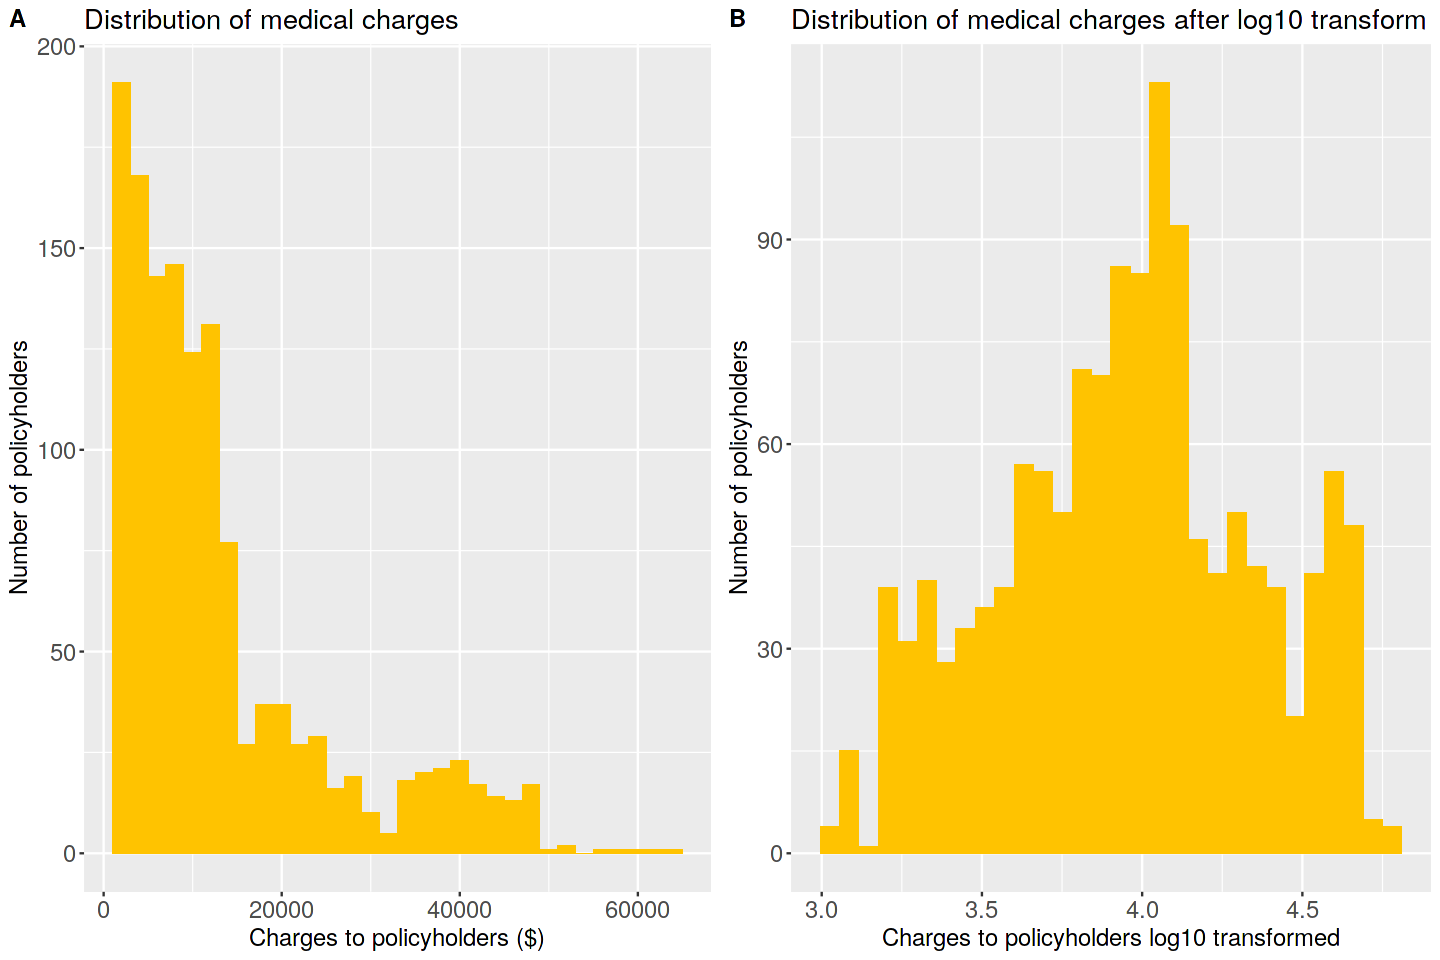

In [19]:
charges_hist <- df %>%
    ggplot(
        aes(x=charges)
        ) +
    geom_histogram(
        binwidth = 2000,
        show.legend = FALSE,
        fill = "#FFC300"
        )+
    labs(
        x = "Charges to policyholders ($)",
        y = "Number of policyholders",
        title = "Distribution of medical charges"
        )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

charges_hist_log10 <- df %>%
    ggplot(
        aes(x=log10(charges))
        ) +
    geom_histogram(
        show.legend = FALSE,
        fill = "#FFC300"
        )+
    labs(
        x = "Charges to policyholders log10 transformed",
        y = "Number of policyholders",
        title = "Distribution of medical charges after log10 transform"
        )+
    # resize text
    theme(
        plot.title = element_text(size=16),
        axis.text = element_text(size=14),
        axis.title = element_text(size=14)
    )

cowplot::plot_grid(
    charges_hist, charges_hist_log10,
    labels="AUTO",
    ncol = 2,
    nrow = 1
    )

The hypotheses for this model are such:

* **Null hypothesis**: there will be no significant prediction of medical expenses by the policyholder's smoking status, BMI score, age, region of residence, sex, and number of dependents covered by the policy.
* **Alternative hypothesis**: there will be significant prediction based on the above mentioned factors.

## 5.1. Split the dataset and train the model

In [20]:
# log10 transform of response variable 
df$logCharges<- log10(df$charges)

# Split the data into training and test sets
set.seed(122)                    # Set the seed to make the partition reproducible
training.samples <- df$logCharges %>%
  createDataPartition(p = 0.8, list = FALSE)
train  <- df[training.samples, ]
test <- df[-training.samples, ]                   

In [21]:
# Train the model on the training dataset
formula <- as.formula("logCharges ~ smoker + bmi + age + children + sex + region")

model <- lm(formula, data = train)

summary(model)


Call:
lm(formula = formula, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40628 -0.09013 -0.02321  0.03314  0.93626 

Coefficients:
                  Estimate Std. Error t value             Pr(>|t|)    
(Intercept)      3.0308795  0.0342260  88.555 < 0.0000000000000002 ***
smokeryes        0.6760329  0.0144515  46.779 < 0.0000000000000002 ***
bmi              0.0058070  0.0009931   5.848  0.00000000663898698 ***
age              0.0153611  0.0004142  37.090 < 0.0000000000000002 ***
children1        0.0538452  0.0146927   3.665             0.000260 ***
children2        0.1286999  0.0161328   7.978  0.00000000000000385 ***
children3        0.1086741  0.0189414   5.737  0.00000001254227630 ***
children4        0.2109837  0.0411729   5.124  0.00000035470555674 ***
children5        0.1835554  0.0552900   3.320             0.000931 ***
sexmale         -0.0304837  0.0115905  -2.630             0.008661 ** 
regionnorthwest -0.0305449  0.0164321  -1.859            

A significant regression equation was found (F(12,1057) = 303.9, *p* < 0.001), with an adjusted R-squared of 0.7789. In other words, the model explains 77.9% of total variance in the sample. Null hypothesis is rejected.

## 5.2. Evaluating the model

In [22]:
# Make predictions on the training dataset
predictions <- model %>% predict(train)
# Model performance
# (a) Calculating the residuals
residuals <- train$logCharges - predictions
# (b) Calculating Root Mean Squared Error
rmse <- sqrt(mean(residuals^2))

rmse %>%
    round(digits=3)

[1] 0.187

In [23]:
# Make predictions on the testing dataset
predictions <- model %>% predict(test)
# Model performance
# (a) Calculating the residuals
residuals <- test$logCharges - predictions
# (b) Calculating Root Mean Squared Error
rmse <- sqrt(mean(residuals^2))

rmse %>%
    round(digits=3)

[1] 0.208

Since the response variable had been transformed, RMSE values have lost their units and are not easily interpretable. To interpret RMSE in a meaningful way, some backtransformations need to be performed.

In [24]:
# Calculating RMSE for training data with backtransformed data

predictions <- model %>% predict(train)
# Model performance
# (a) Calculating the residuals
residuals <- 10^train$logCharges - 10^predictions # backtransform measured and predicted values
# (b) Calculating Root Mean Squared Error
rmse <- sqrt(mean(residuals^2))

round(rmse)

[1] 8334

In [25]:
# Calculating RMSE for testing data with backtransformed data

predictions <- model %>% predict(test)
# Model performance
# (a) Calculating the residuals
residuals <- 10^test$logCharges - 10^predictions # backtransform measured and predicted values
# (b) Calculating Root Mean Squared Error
rmse <- sqrt(mean(residuals^2))

round(rmse)

[1] 9000

To measure robustness of the model, an absolute measure of fit - RMSE was calculated, RMSE (test set) = 0.208, RMSE (training set) = 0.187. This is an indicator that the model is not overfit, however, further investigation is needed to confirm this. After backtransforming the residuals, the RMSE for the test set was \\$9000, meaning the model's predictions are usually off by this amount.

# 6. Discussion and conclusions

Smoking having the strongest effect on medical expenses is quite expected.

Increases in the BMI score lead to rather small expense increases, however, it is worth pointing out that normal BMI scores are not indicative of ill health. Only people in the underweight (BMI < 18.5), overweight (BMI 25.0 to 29.9), and obese (BMI $\geq$ 30) ranges would be expected to have poorer health outcomes.

Same should be said of the effect of aging - 22-year-olds would be expected to enjoy the same level of health as 18-year-olds despite being 4 years older. However, middle aged and elderly people will most likely see a rapid decline in health year by year.

Medical expenses increasing with increased number of dependents is to be expected. However, having three dependents covered by insurance seems to be cheaper than having two dependents, and five dependents sees a lesser increase in charges than four. This may be explained by the uneven number of observations in each group. For example, no dependents group has 574 observations when five dependents group only has 18.

It is also interesting to note that even though the median difference of medical charges between men and women is only $43, the relationship between sex and medical charges was significant in the multiple linear regression model.

Lastly, whether the model is robust can only be determined knowing what is the acceptable cost of error. Being able to explain 77.9% of the total variance with an RMSE of \\$9000 may well be enough if the company can deal with the potential mispredictions.

# 7. References

1. Fulton, B. D. (2017). Health care market concentration trends in the United States: evidence and policy responses. Health Affairs, 36(9), 1530-1538.
2. Ho, K. (2009). Insurer-provider networks in the medical care market. American Economic Review, 99(1), 393-430.
3. Frees, E. W. (2009). Regression modeling with actuarial and financial applications. Cambridge University Press.
4. Benjamini, Y., & Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. Journal of the Royal statistical society: series B (Methodological), 57(1), 289-300.